## libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import re
import urllib
import collections
from sklearn.model_selection import train_test_split

In [ ]:
%%capture
!pip install transformers

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## process data 

In [ ]:
path = "drive/MyDrive/dataset_en_train.json"
df = pd.read_json(path, lines = True).rename(columns={'stars':'star_rating'})

In [ ]:
df = df[['star_rating','review_body','product_category']]
df = df.dropna()
#df['star_rating']= np.where(df['star_rating']>=4,1,0) ##asi un poco mas balanceado 
#df = df.head(10000)
len(df)

200000

In [ ]:
INPUT_FEATURE = 'review_body'
OUTPUT_FEATURE = 'product_category'

X = df[INPUT_FEATURE].values
y = df[OUTPUT_FEATURE].values
df.head(5)

,star_rating,review_body,product_category
0,1,Arrived broken. Manufacturer defect. Two of th...,furniture
1,1,the cabinet dot were all detached from backing...,home_improvement
2,1,I received my first order of this product and ...,home
3,1,This product is a piece of shit. Do not buy. D...,wireless
4,1,went through 3 in one day doesn't fit correct ...,pc


### divide data and create data splits

In [ ]:
def train_val_test_split(X, y, val_size, test_size, shuffle):
    """Split data into train/val/test datasets."""
    

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, stratify=y_train, shuffle=shuffle)
   
    return X_train, X_val, X_test, y_train, y_val, y_test



TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15
SHUFFLE = True

# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, val_size=VAL_SIZE, test_size=TEST_SIZE, shuffle=SHUFFLE)
class_counts = dict(collections.Counter(y))
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[1]} → {y_train[1]}")
print (f"Classes: {class_counts}")



X_train: (144500,), y_train: (144500,)
X_val: (25500,), y_val: (25500,)
X_test: (30000,), y_test: (30000,)
Sample point: This dress is nice and light, flowy, and soft. Perfect for warm summer days. I only wish that this came in an x-small as my usual size, a small, fit a little more loose than I would like. → apparel
Classes: {'furniture': 2984, 'home_improvement': 7136, 'home': 17679, 'wireless': 15717, 'pc': 6401, 'industrial_supplies': 1994, 'kitchen': 10382, 'apparel': 15951, 'automotive': 7506, 'camera': 2139, 'lawn_and_garden': 7327, 'watch': 761, 'beauty': 12091, 'pet_products': 7082, 'drugstore': 11730, 'electronics': 6186, 'toy': 8745, 'digital_ebook_purchase': 6749, 'book': 3756, 'jewelry': 2747, 'sports': 8277, 'other': 13418, 'baby_product': 3150, 'video_games': 775, 'office_product': 5521, 'grocery': 4730, 'digital_video_download': 1364, 'luggage': 1328, 'shoes': 5197, 'musical_instruments': 1102, 'personal_care_appliances': 75}


In [ ]:
y_train[1]

'apparel'

## label encoder para transformar categorias en clases numericas

In [ ]:
import itertools

In [ ]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y_train)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, 'w') as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, 'r') as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
NUM_CLASSES = len(label_encoder)
label_encoder.class_to_index

{'apparel': 0,
 'automotive': 1,
 'baby_product': 2,
 'beauty': 3,
 'book': 4,
 'camera': 5,
 'digital_ebook_purchase': 6,
 'digital_video_download': 7,
 'drugstore': 8,
 'electronics': 9,
 'furniture': 10,
 'grocery': 11,
 'home': 12,
 'home_improvement': 13,
 'industrial_supplies': 14,
 'jewelry': 15,
 'kitchen': 16,
 'lawn_and_garden': 17,
 'luggage': 18,
 'musical_instruments': 19,
 'office_product': 20,
 'other': 21,
 'pc': 22,
 'personal_care_appliances': 23,
 'pet_products': 24,
 'shoes': 25,
 'sports': 26,
 'toy': 27,
 'video_games': 28,
 'watch': 29,
 'wireless': 30}

In [ ]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: toy
y_train[0]: 27


## tokenization and input formatting for bert

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
## para probar 
print("original: ", X[1])
print("tokenized", tokenizer.tokenize(X[1]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(X[1])))

original:  the cabinet dot were all detached from backing... got me
tokenized ['the', 'cabinet', 'dot', 'were', 'all', 'detached', 'from', 'backing', '.', '.', '.', 'got', 'me']
Token IDs:  [1996, 5239, 11089, 2020, 2035, 12230, 2013, 5150, 1012, 1012, 1012, 2288, 2033]


tenemos que añadir tokens especiales para que los entienda BERT

In [ ]:
%%capture
input_ids = []

for rev in X_train:
    enconde_rev = tokenizer.encode(rev,add_special_tokens = True)
    input_ids.append(enconde_rev)

Token indices sequence length is longer than the specified maximum sequence length for this model (576 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
%%capture
input_ids_test = []

for rev in X_test:
    enconde_rev = tokenizer.encode(rev,add_special_tokens = True)
    input_ids_test.append(enconde_rev)

In [ ]:
#tokenizer.encode??

In [ ]:
print('Original: ', X_train[1])
print('Token IDs:', input_ids[1])

Original:  This dress is nice and light, flowy, and soft. Perfect for warm summer days. I only wish that this came in an x-small as my usual size, a small, fit a little more loose than I would like.
Token IDs: [101, 2023, 4377, 2003, 3835, 1998, 2422, 1010, 4834, 2100, 1010, 1998, 3730, 1012, 3819, 2005, 4010, 2621, 2420, 1012, 1045, 2069, 4299, 2008, 2023, 2234, 1999, 2019, 1060, 1011, 2235, 2004, 2026, 5156, 2946, 1010, 1037, 2235, 1010, 4906, 1037, 2210, 2062, 6065, 2084, 1045, 2052, 2066, 1012, 102]


In [ ]:
print('Original: ', X_test[1])
print('Token IDs:', input_ids_test[1])

Original:  Smaller than I thought but cute.
Token IDs: [101, 3760, 2084, 1045, 2245, 2021, 10140, 1012, 102]


## padding and truncating

In [ ]:
print('Max review length: ', max([len(rev) for sen in input_ids]))
print('Max review length: ', max([len(rev) for sen in input_ids_test]))

Max review length:  201
Max review length:  201


In [ ]:
%%capture
!pip install tensorflow
!pip install Keras
import tensorflow as tf
import tensorflow 

from tensorflow import keras

from keras.layers import Dense

from keras.preprocessing.sequence import pad_sequences


In [ ]:
MAX_LEN = 256

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")


print('\nDone.')


Padding/truncating all sentences to 256 values...

Padding token: "[PAD]", ID: 0

Done.


## attention masks

define que tokens son palabras reales y las distingue del padding,
el vocab de bert no usa ID 0 entonces si el ID es 0 es padding.

In [ ]:
att_masks = []

att_masks_test = []

for review in input_ids:
    attention_mask = [int(token_id > 0) for token_id in review]
    att_masks.append(attention_mask)
    
for review in input_ids_test:
    attention_mask = [int(token_id > 0) for token_id in review]
    att_masks_test.append(attention_mask)

## convert to pytorch datatypes

In [ ]:
input_ids = torch.tensor(input_ids)
input_ids_test = torch.tensor(input_ids_test)

In [ ]:
y_train= torch.tensor(y_train)
y_test = torch.tensor(y_test)

In [ ]:
att_masks = torch.tensor(att_masks)
att_masks_test = torch.tensor(att_masks_test)

## creamos DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
batch_size = 32 # recomendado

# DATALOADER para el train data
train_data = TensorDataset(input_ids,att_masks,y_train)
train_sampler= RandomSampler(train_data)
train_dataloader= DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)


In [ ]:
#DATALOADER para el test data
test_data = TensorDataset(input_ids_test,att_masks_test,y_test)
test_sampler= RandomSampler(test_data)
test_dataloader= DataLoader(test_data,sampler=test_sampler,batch_size=batch_size)




# Train el Modelo de Clasificacion 

## BertForSequenceClassification

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                        num_labels= 31,
                                                        output_attentions = False,
                                                        output_hidden_states= False)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
 ## ponemos todos los parametros como lista
    
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## optimizer y leaning rate

In [ ]:
optimizer = AdamW(model.parameters(),lr = 2e-5,eps= 1e-8)

In [ ]:
from transformers import get_linear_schedule_with_warmup

## de la documentacion :

#Create a schedule with a constant learning rate 
#preceded by a warmup period during which the learning rate 
#increases linearly between 0 and the initial lr set 
#in the optimizer.

epochs= 4
total_steps= len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps = 0, num_training_steps = total_steps)
scheduler

## training loop

In [ ]:
import numpy as np

# Funcion para calcular la accuracy (pred-labels)
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
## para medir los tiempos
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


Training

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Guarda las perdidas (Average) después de cada epoch para poder plotear despues
loss_values = []

# para cada epoch:
for epoch_i in range(0, epochs):
    
    
    #Training
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()        

    
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
  


    ## Validation
   
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in test_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")

   


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  4,516.    Elapsed: 0:00:59.
  Batch    80  of  4,516.    Elapsed: 0:01:57.
  Batch   120  of  4,516.    Elapsed: 0:02:55.
  Batch   160  of  4,516.    Elapsed: 0:03:53.
  Batch   200  of  4,516.    Elapsed: 0:04:51.
  Batch   240  of  4,516.    Elapsed: 0:05:50.
  Batch   280  of  4,516.    Elapsed: 0:06:48.
  Batch   320  of  4,516.    Elapsed: 0:07:46.
  Batch   360  of  4,516.    Elapsed: 0:08:44.
  Batch   400  of  4,516.    Elapsed: 0:09:42.
  Batch   440  of  4,516.    Elapsed: 0:10:40.
  Batch   480  of  4,516.    Elapsed: 0:11:39.
  Batch   520  of  4,516.    Elapsed: 0:12:37.
  Batch   560  of  4,516.    Elapsed: 0:13:35.
  Batch   600  of  4,516.    Elapsed: 0:14:33.
  Batch   640  of  4,516.    Elapsed: 0:15:31.
  Batch   680  of  4,516.    Elapsed: 0:16:30.
  Batch   720  of  4,516.    Elapsed: 0:17:28.
  Batch   760  of  4,516.    Elapsed: 0:18:26.
  Batch   800  of  4,516.    Elapsed: 0:19:25.
  Batch   840  of

## graficos

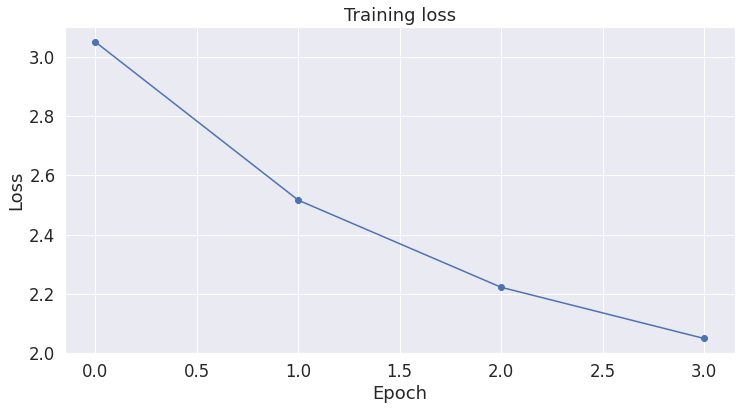

In [ ]:
### GRAFICO PRIMER RUN CON 10k entradas 

import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

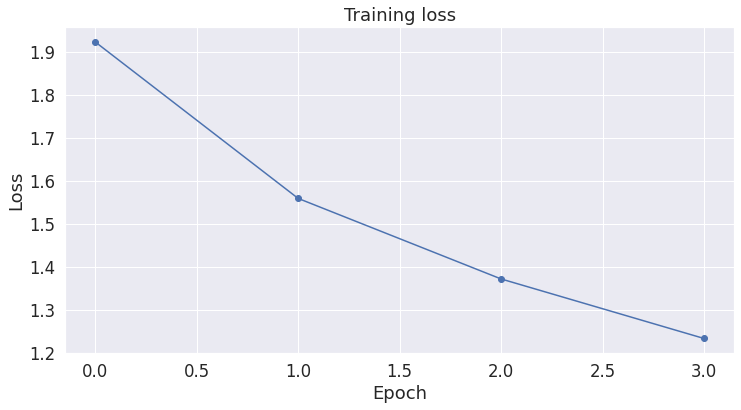

In [ ]:
### con 200k entradas


import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()